# Вариант 9

Рассматривается система линейных гиперболических уравнений:

\begin{gather*}
    \frac { \partial \mathbf { u } } { \partial t } + \mathbf { A } \frac { \partial \mathbf { u } } { \partial x } = \mathbf { b } ( x ) , ~ 0 \leqslant x \leqslant 1, ~ 0 \leqslant t \leqslant 1, ~~ 
    \mathbf { u } ( x , 0 ) = \left( \begin{array} { c } { 2 x - x ^ { 3 } } \\ { x ^ { 3 } } \\ { x ^ { 2 } + 1 } \end{array} \right) \\
    \mathbf { A } = \left( \begin{array} { c c c } { - 21 / 2 } & { 27 / 2 } & { 3 / 2 } \\ { - 7 } & { 9 } & { 1 } \\ { 13 / 2 } & { - 19 / 2 } & { - 3 / 2 } \end{array} \right), ~~ 
    \mathbf { b } ( x ) = \left( \begin{array} { l } { 0 } \\ { 0 } \\ { 0 } \end{array} \right)
\end{gather*}

Привести систему к характеристическому виду, предложить корректную постановку граничных условий.

Решить численно систему уравенний с использованием двух указанных схем.
Для каждой из схем выписать первое дифференциальное приближение (ПДП), 
определить, диссипативная или дисперсионная ошибка преобладает.
Монотонна ли схема? Оценить апостериорно порядок сходимости каждой схемы.

### Разностные схемы
Схемы приводятся для модельного уравнения $ \frac { \partial u } { \partial t } + a \frac { \partial u } { \partial x } = 0 , ~ a = \text { const } > 0 $ на сетке $ x _ { m } = m h , ~ m = 0 \dots M , ~ M h = 1 ; ~ t ^ { n } = n \tau , ~ n = 0 \dots N, ~ N \tau = 1 $. При необходимости преобразовать схемы для случая $ a = \text{const} < 0 $.

1) "Неявный" правый уголок (схема бегущего счета)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n + 1 } - u _ { m } ^ { n + 1 } } { h } = 0
\end{equation}

2) Центральная схема второго порядка (Лакса-Вендроффа, МакКормака)
\begin{equation}
    \frac { u _ { m } ^ { n + 1 } - u _ { m } ^ { n } } { \tau } + a \frac { u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } } { 2 h } = \frac { a ^ { 2 } \tau } { 2 } \frac { u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } } { h ^ { 2 } }
\end{equation}

## Анализ системы
Приведем систему к характеристическому виду. Для этого найдем левые собственные вектора (см. код ниже), затем приведем систему к каноническому виду. Это реализовано ниже.

In [1]:
# Подготовительный этап
from IPython.display import display, Math, Latex, Markdown
import pprint
import sympy as sp
from sympy import Matrix, Rational, latex, symbols
import numpy as np
from scipy.linalg import eig
x, u, t = sp.symbols('x u t')

In [2]:
# Вбиваем данные задачи
A = Matrix([
    [Rational(-21, 2), Rational(27, 2), Rational(3, 2)], 
    [-7, 9, 1], 
    [Rational(13, 2), Rational(-19, 2), Rational(-3, 2)]
])
#A = sp.diag(10, 5, 30)
b = Matrix([0, 0, 0])
u = Matrix([x + x**3, x**3, x**2 + 1])

In [3]:
# Ищем собственные вектора и собственные значения
print('Собственные значения и собственные вектора:')
tmp = A.T.eigenvects()
# Выводим это на экран
for i, tup in enumerate(tmp):
    display(Math(
        '\lambda_{0} = {1}; ~ \omega_{0} = {2}'
        .format( str(i+1), tup[0], latex(tup[2][0]) )
    ))

Собственные значения и собственные вектора:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [4]:
# Считаем матрицы, которые нам потом пригодятся
Omega = Matrix([Matrix(i[2][0]).T for i in tmp])
lambdas = [i[0] for i in tmp]
Lambda = sp.diag(*lambdas)

In [5]:
display(Latex(r'Запишем матрицу перехода: $ \Omega = {}$'.format(latex(Omega))),
        Latex(r'а также обратную ей: $ \Omega^{{-1}} = {}$'.format(latex(Omega**(-1)))),
        Math(r'A = \Omega^{-1} \Lambda \Omega')
       )

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

In [6]:
I = Omega*u
I_funcs = [sp.lambdify(x, I[i]) for i in range(Omega.shape[0])]
display(
    Math(r'\mathbf{{I}} (x, 0) = {}, ~~~~ \Lambda = {}'
         .format( latex(I), latex(Lambda) )
        )
)

<IPython.core.display.Math object>

#### О постановке граничных условий:
В нашей системе есть 0 положительных собственных значений, 1 нулевое и 2 
отрицательных. 
Значит, на левой границе не нужно ставить граничных условий, на правой же границе нужно 2.
В нулевом значении достаточно задать только начальное условие.

Попробуем поставить граничные условия вида:

\begin{equation}
u|_{t = 0} = f(x), ~~ u|_{x = 1} = g(t)
\end{equation} 

На них будет наложено необходимое условие разрешимости:
$ f(1) = g(0) $.
Потребуем также, чтобы производная не терпела разрыв: $ f'(1) = g'(0) $. Итого:

\begin{gather}
    \boxed{
    f(1) = g(0) \\
    f'(1) = g'(0)
    }
\end{gather}

In [7]:
display(
    Markdown('Итак, мы получили {} уравнения:'.format(Lambda.shape[0])),
    *[
        Math( 
            (r'\cfrac{{\partial I_{i} }} {{\partial t}} {sign}{koeff}\cdot'+ 
             r'\cfrac{{\partial I_{i} }} {{\partial x}} = {left_part}' +
             ', ~ I_{i} (x, 0) =' 
            ).format(
                i=(k+1), 
                sign='+' if lambdas[k] >= 0 else '-',
                koeff=abs(lambdas[k]),
                size=Lambda.shape[0],
                left_part=b[k]
            )
            + sp.latex( (Omega*u)[k] )
        ) for k in range(Lambda.shape[0])
    ]
)

Итак, мы получили 3 уравнения:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Последнее уравнение решается просто:
\begin{equation*}
    I _ { 3 } ( x , t ) = \frac { x ^ { 3 } } { 3 } - \frac { 2 x } { 3 }
\end{equation*}

In [81]:
def make_grid(x_min, x_max, t_min, 
              t_max, h, tau, fictive_x=True):
    if fictive_x:
        x_grid = np.arange(x_min-h/2, x_max+h/2+h/4, h/2)
    else:
        x_grid = np.arange(x_min, x_max+h/4, h/2)
    t_grid = np.arange(t_min, t_max+tau/2, tau)
    # Матрица решений
    T = np.zeros((x_grid.shape[0], t_grid.shape[0]))
    return T, x_grid, t_grid

## Решение схемой неявного правого уголка
Данная схема преобразуется к виду:

\begin{equation}
    u_m^{n+1} (1 - \sigma) + \sigma u_{m+1}^{n+1} = u_m^n, ~~ \sigma = \frac{a \tau}{h}
\end{equation}

Здесь нам придется на каждой итерации решать систему из линейных уравений:
\begin{gather*}
    \mathbf{A} u^{n+1} = \mathbf{b} \\
    A = 
        \begin{bmatrix}
            1-\sigma & \sigma & 0 & \dots & 0 \\
            0 & 1-\sigma & \sigma & \dots & 0 \\
            \dots & \dots & \dots & \dots & \dots \\
            0 & \dots & 0 & 1-\sigma & \sigma
        \end{bmatrix}, ~~
    b = 
    \begin{bmatrix}
        u_{-1}^n \\ u_0^n \\ \dots \\ u_{M-1}^n
    \end{bmatrix}
\end{gather*}

In [82]:
from numba import jit
    
@jit(nopython=True)
def ugolok_kernel(T, sigma):
    """
    Предполагается, что граничные условия УЖЕ заданы
    """
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        # Решим систему и запишем результаты в следующую итерацию времени
        #count_current_x_layer(T, n, sigma)
        for m in range(M-2, -1, -1):
            T[m, n+1] = 1/(1-sigma)*T[m,n] - sigma/(1-sigma)*T[m+1,n+1]
    # Выкинем фиктивные узлы в возвращаемом значении
    return T[1:-1, :]

In [107]:
# Pure function
def calculate_all(kernel, timezero_funcs, xzero_funcs,
                  a, h, tau, 
                  x_min=0, x_max=1, t_min=0, t_max=1):
    """
    Делает подсчеты с заданным ядром метода для всех компонент
    """
    tmp = []
    # Создаем сетку
    T, x_grid, t_grid = make_grid(x_min, x_max, t_min, 
                                   t_max, h, tau, fictive_x=True)
    # Для каждой компоненты
    for i in range(len(timezero_funcs)):
        # Считаем значения
        func_t, func_x, a_curr = timezero_funcs[i], xzero_funcs[i], np.float64(a[i])
        # Начальные условия
        T[:,0] = func_t(x_grid)
        # Граничные условия
        T[-1,:] = func_x(t_grid)
        # Приводим все к double
        T = T.astype('double')
        # Высчитываем sigma
        sigma = np.double(a_curr*tau/h)
        # Вызываем калькулятор
        tmp.append(kernel(T, sigma).T)
    return tmp, x_grid[1:-1], t_grid

In [108]:
h, tau = 10**-3, 10**-3/4

In [109]:
#xzero_funcs = [lambda x: np.ones_like(x), lambda x: np.ones_like(x), lambda x: np.zeros_like(x)]
xzero_funcs = [
    lambda t: np.sin(10*t)+I_funcs[0](1),
    lambda t: np.sin(10*t)+I_funcs[1](1),
    lambda t: np.sin(10*t)+I_funcs[2](1)
]
tmp = calculate_all(ugolok_kernel, I_funcs, xzero_funcs, lambdas, h, tau)

In [110]:
T, x, t = np.array(tmp[0]), tmp[1], tmp[2]

In [112]:
omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)

In [113]:
u_1 = solution[:,:,0]
u_2 = solution[:,:,1]
u_3 = solution[:,:,2]

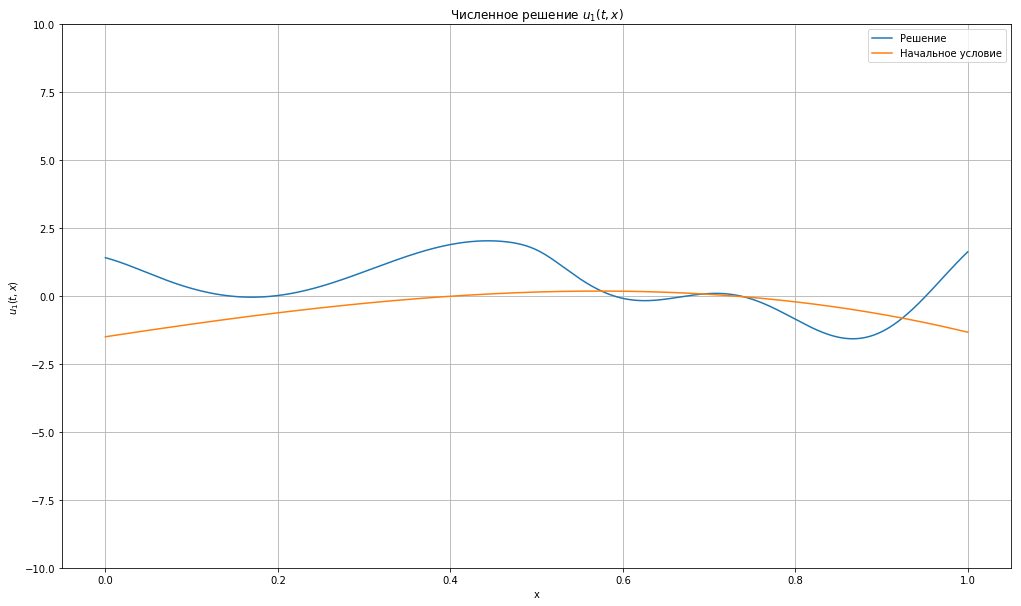

In [114]:
# Строим анимацию для первого графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_1[:,0], label='Решение')
initial, = ax.plot(x, u_1[:,0], label='Начальное условие')
#ax.set_ylim([u_1.min()-0.1, u_1.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_1(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_1(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_1[:,i*10])  # update the data.
    initial.set_ydata(u_1[:,0])  # update the data.x
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_1.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u1.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


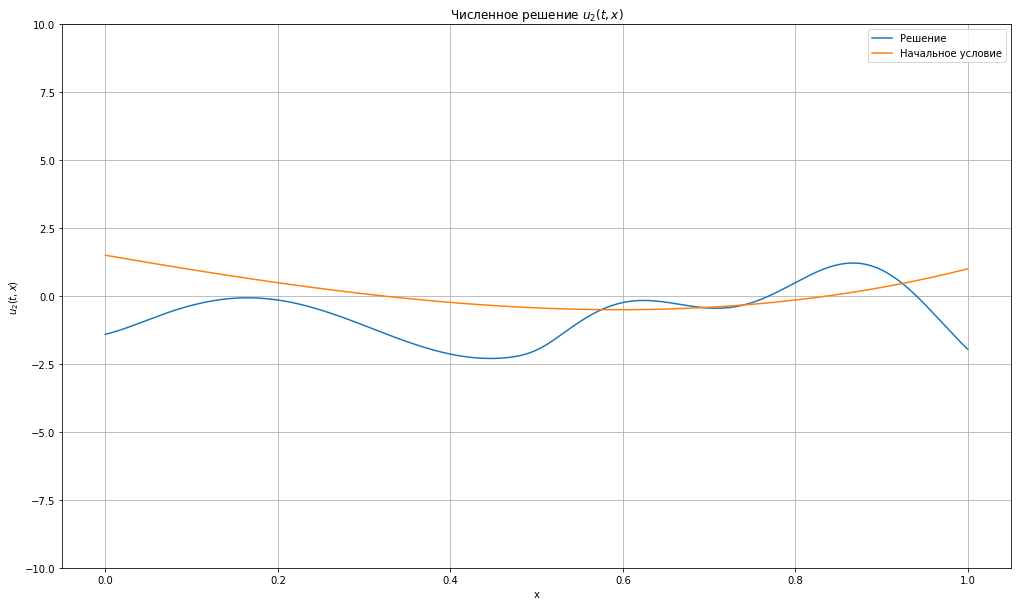

In [115]:
# Строим анимацию для второго графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_2[:,0], label='Решение')
initial, = ax.plot(x, u_2[:,0], label='Начальное условие')
#ax.set_ylim([u_2.min()-0.1, u_2.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_2(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_2(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_2[:,i*10])  # update the data.
    initial.set_ydata(u_2[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_2.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u2.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


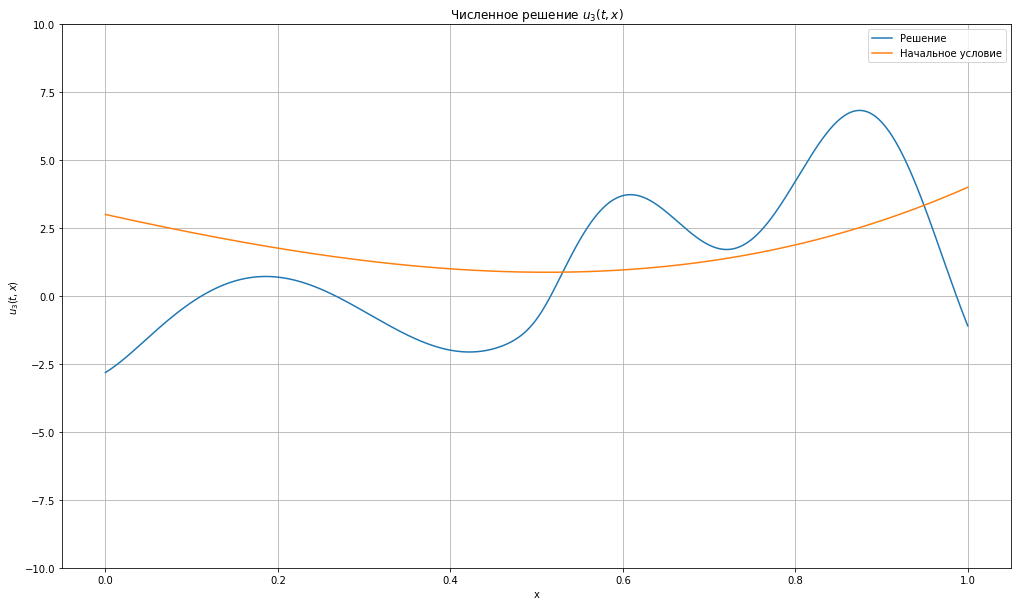

In [116]:
# Строим анимацию для третьего графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_3[:,0], label='Решение')
initial, = ax.plot(x, u_3[:,0], label='Начальное условие')
#ax.set_ylim([u_3.min()-0.1, u_3.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_3(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_3(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_3[:,i*10])  # update the data.
    initial.set_ydata(u_3[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_3.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_ugol_u3.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


## Решение центральной схемой второго порядка

Данная схема преобразуется к виду:
\begin{equation*}
    u _ { n } ^ { n + 1 } = u _ { m } ^ { n } - \frac { a \tau } { 2 h } \left( u _ { m + 1 } ^ { n } - u _ { m - 1 } ^ { n } \right) + \frac { a ^ { 2 } \tau ^ { 2 } } { 2 h ^ { 2 } } \left( u _ { m + 1 } ^ { n } - 2 u _ { m } ^ { n } + u _ { m - 1 } ^ { n } \right)
\end{equation*}
Мы введем два фиктивных узла по сетке $x$ (слева и справа). На каждой итерации по $n$ (время) значения в фиктивных узлах будем пересчитывать через линейную интерполяцию по двум предыдущим точкам (поскольку $h$ мало, это должно хватить).

In [117]:
from numba import jit
@jit(nopython=True, parallel=True)
def laks_kernel(T, sigma):
    """
    Основной калькулятор. Предполагается, что в `T` уже включены начальные данные.
    НАЧАЛЬНЫЕ УСЛОВИЯ ЗАДАНЫ СПРАВА!!! Я не хочу реализовывать это для начальных условий слева :)
    """
    M, N = T.shape[0], T.shape[1]
    for n in range(0, N-1):
        for m in range(1, M-1):
            T[m, n+1] = T[m, n] - sigma/2*(T[m+1, n] - T[m-1, n]) \
            + sigma**2/2* (T[m+1, n] - 2*T[m, n] + T[m-1, n])
        # Линейная экстраполяция слева
        T[0, n+1] = 2*T[1, n+1] - T[2, n+1]
        # А вот справа у нас уже есть начальные условия
        # Линейная экстраполяция справа
        #T[M-1, n+1] = 2*T[M-2, n+1] - T[M-3, n+1]
    return T[1:-1,:]

In [118]:
h, tau = 10**-3, 10**-3/4

In [119]:
#xzero_funcs = [lambda x: np.ones_like(x), lambda x: np.ones_like(x), lambda x: np.zeros_like(x)]
xzero_funcs = [
    lambda t: np.sin(10*t)+I_funcs[0](1),
    lambda t: np.sin(10*t)+I_funcs[1](1),
    lambda t: np.sin(10*t)+I_funcs[2](1)
]
tmp = calculate_all(laks_kernel, I_funcs, xzero_funcs, lambdas, h, tau)

In [120]:
T, x, t = np.array(tmp[0]), tmp[1], tmp[2]

In [121]:
omega_rev = np.array(Omega**-1).astype(np.float64)
solution = T.T.dot(omega_rev)

In [122]:
u_1 = solution[:,:,0]
u_2 = solution[:,:,1]
u_3 = solution[:,:,2]

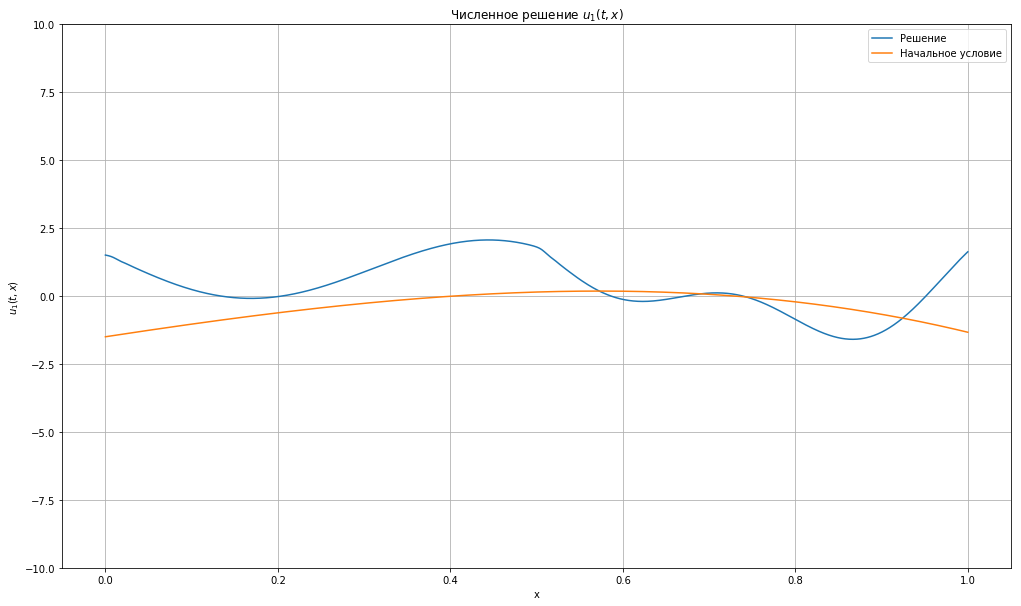

In [123]:
# Строим анимацию для первого графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_1[:,0], label='Решение')
initial, = ax.plot(x, u_1[:,0], label='Начальное условие')
#ax.set_ylim([u_1.min()-0.1, u_1.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_1(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_1(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_1[:,i*10])  # update the data.
    initial.set_ydata(u_1[:,0])  # update the data.x
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_1.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u1.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


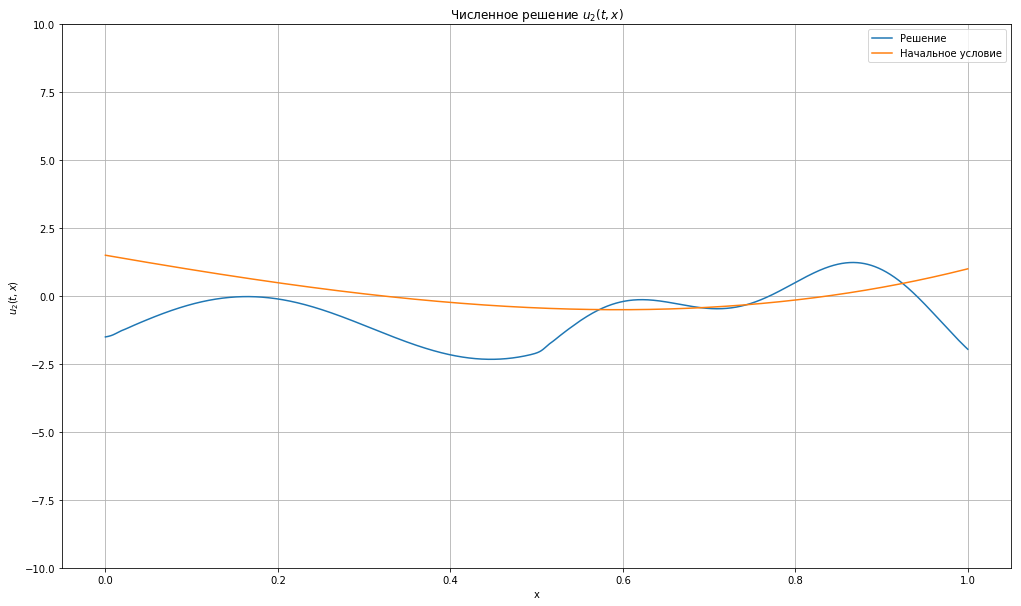

In [124]:
# Строим анимацию для второго графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_2[:,0], label='Решение')
initial, = ax.plot(x, u_2[:,0], label='Начальное условие')
#ax.set_ylim([u_2.min()-0.1, u_2.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_2(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_2(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_2[:,i*10])  # update the data.
    initial.set_ydata(u_2[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_2.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u2.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)


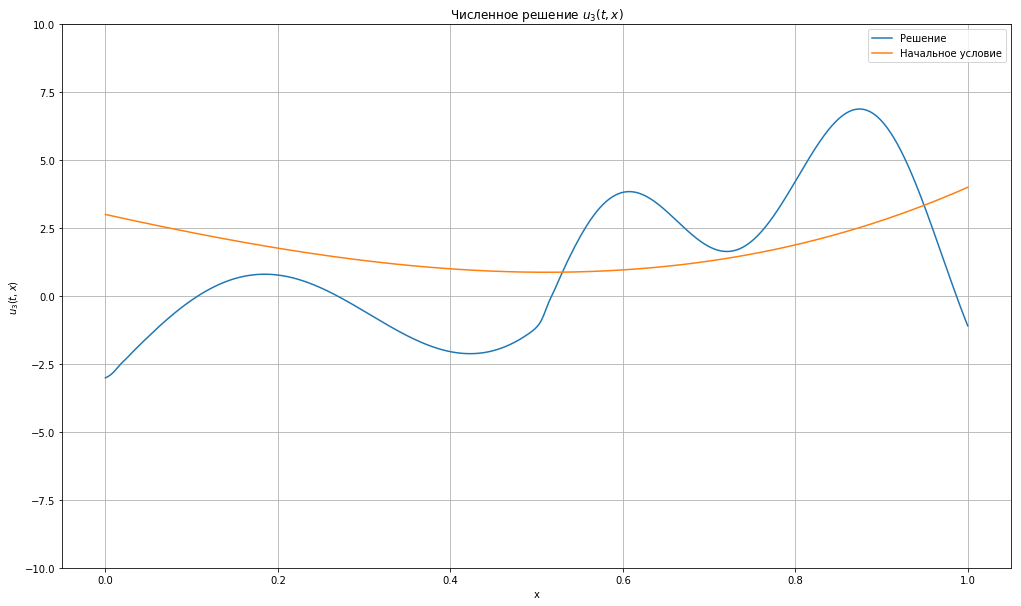

In [125]:
# Строим анимацию для третьего графика

import matplotlib.pyplot as plt
from matplotlib import animation
fig, ax = plt.subplots(figsize=(17,10))

line, = ax.plot(x, u_3[:,0], label='Решение')
initial, = ax.plot(x, u_3[:,0], label='Начальное условие')
#ax.set_ylim([u_3.min()-0.1, u_3.max()+0.1])
ax.set_ylim([-10, 10])
ax.title.set_text('Численное решение $u_3(t, x)$')
ax.set_xlabel("x")
ax.set_ylabel('$u_3(t, x)$')
ax.legend()
ax.grid()


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    initial.set_ydata([np.nan] * len(x))
    return line, initial,


def animate(i):
    line.set_ydata(u_3[:,i*10])  # update the data.
    initial.set_ydata(u_3[:,0])  # update the data.
    return line, initial,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=30, blit=True, save_count=(u_3.shape[1]-1)/10)

# To save the animation, use e.g.
#
ani.save("movie_laks_u3.mp4")
#
# or
#
#from matplotlib.animation import FFMpegWriter
#writer = FFMpegWriter(fps=200, metadata=dict(artist='Me'), bitrate=1800)
#ani.save("movie1.mp4", writer=writer)
